In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [2]:
plt.rcParams["image.interpolation"] = "nearest"

In [3]:
%matplotlib widget

### Utilitity function definitions

In [15]:
def make_active_mask(img, loc):
    """
    Create an active pixel mask
    """
    
    # -- create zeros
    active = np.zeros_like(img).astype(bool)

    # -- fill locations
    active[loc[:, 0], loc[:, 1]] = True
    
    return active

In [4]:
def subset_chisq_index(waves, specs, sig, thr=1.2):
    """
    Subset by reduced chisq.
    """
    
    # -- for each spectrum get chi^2
    slp, off = np.polyfit(waves, specs.T, 1)
    model = (slp * waves[:, None] + off).T
    chisq = ((specs - model)**2 / sig**2).mean(axis=1)

    return chisq > thr

In [5]:
# -- standardize a 2D array
stand2d = lambda x: (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)

# -- Min/Max a 1D array
minmax = lambda x: (x - x.min()) / (x.max() - x.min())

In [6]:
def correlate_templates(arr1, arr2):
    """
    Get correlation coefficients and labels for templates
    """

    # -- get the correlation coefficients
    ccs = np.dot(stand2d(arr1), stand2d(arr2).T) / arr1.shape[1]
    labs = ccs.argmax(axis=1)
    
    return ccs, labs

In [7]:
def plot_labels(active, loc, ind, labs, year):
    """
    Plot the template correlation labels.
    """
    
    # -- add unknowns to labels
    plabs = np.zeros(ind.size, dtype=int) - 1
    plabs[ind] = labs

    # -- set the colors
    clrs = ["r", "r", "y", "b", "b", "b", "b", "b", "cyan", "cyan", 
            "purple", "purple", "purple", "purple", "b", "b", "b", "b", "cyan", "cyan"]

    # -- set the plot order
    pord = [3, 4, 5, 6, 7, 14, 15, 16, 17, 0, 1, 8, 9, 18, 19, 10, 11, 12, 13, 2]

    # -- plot it
    plt.close("all")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis("off")
    ax.imshow(active, cmap="gist_gray", aspect="auto")
    for ii in pord:
        nsrc = (plabs == ii).sum()
        if nsrc > 0:
            ax.scatter(loc[plabs == ii, 1], loc[plabs == ii, 0], c=clrs[ii], s=2)

    # -- make a legend
    ax.plot([], [], "r", marker="o", lw=0, label="High Pressure Sodium", ms=5)
    ax.plot([], [], "b", marker="o", lw=0, label="LED", ms=5)
    ax.plot([], [], "y", marker="o", lw=0, label="Incandescent", ms=5)
    ax.plot([], [], "purple", marker="o", lw=0, label="Fluorescent", ms=5)
    ax.plot([], [], "c", marker="o", lw=0, label="Metal Halide", ms=5)
    ax.plot([], [], "w", marker="o", lw=0, label="Unknown", ms=5)
    ax.legend(fontsize=8, ncol=6, loc="upper center")

    # -- set the title
    txt = ax.set_title("{0} Lighting Technologies (template correlations)".format(year))
    
    return

### Load data

In [8]:
# -- get spectra
specs13all = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T
specs18all = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T

# -- load source locations
loc13 = np.load("../output/hsi0_overlap_location_bridge.npy")
loc18 = np.load("../output/hsi1_overlap_location_bridge.npy")

# -- load waves range for both scans
waves13 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves18 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

# -- load templates, waves, and names
templs = np.load("../output/final_spectra_20.npy")
names = np.load("../output/final_name_20.npy")
wavest = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

# -- create 2013 active pixel mask
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")
active13 = make_active_mask(imgL_hsi0, loc13)

# -- create 2018 active pixel mask
imgL_hsi1 = np.load("../output/graham_hall_upload/img3_overlap.npy")
active18 = make_active_mask(imgL_hsi1, loc18)

# -- get quantum efficiency
qe = pd.read_csv("../data/hsi1-qe.csv", delimiter="\t")

# -- interpolate onto 2018
specs13allin = np.array([np.interp(waves18, waves13, i) for i in specs13all])
templsin = np.array([np.interp(waves18, wavest, i) for i in templs])
qe = np.interp(waves18, qe["wavelength_nm"], qe["quantum_efficiency"]) * 0.01

# -- "correct" templates for QE
templsinqe = templsin * qe

# -- standardize templates
templsinqest = stand2d(templsinqe)

In [9]:
# -- find the noise levels (note we are overestimating b/c of signal looks like about 10%)
sig13 = np.median(specs13allin.std(axis=1)) / 1.1

# -- find the noise levels (note we are overestimating b/c of signal looks like about 100%)
sig18 = np.median(specs18all.std(axis=1)) / 2.0

# -- subset
ind13 = subset_chisq_index(waves18, specs13allin, sig13)
ind18 = subset_chisq_index(waves18, specs18all, sig18)
specs13in = specs13allin[ind13]
specs18 = specs18all[ind18]

### Effect of Quantum Efficiency

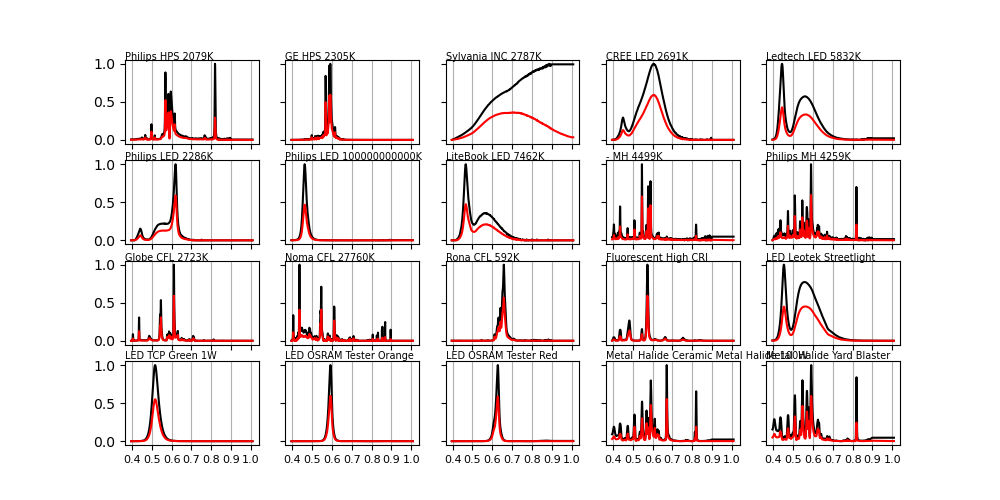

In [10]:
# -- check effect of quantum efficiency on templates
plt.close("all")
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(10, 5))
for ii in range(20):
    tax = ax[ii // 5, ii % 5]
    tax.plot(waves18 * 1e-3, minmax(templsin[ii]), "k")
    tax.plot(waves18 * 1e-3, minmax(templsin[ii]) * qe, "red")
    tax.set_title(names[ii], loc="left", fontsize=7, va="top")
    tax.set_xticks(np.arange(0.4, 1.1, 0.1))
    tax.set_xticklabels(np.arange(0.4, 1.1, 0.1).round(1), fontsize=8)
    tax.grid(":", axis="x")

### First 2013 correlations

In [11]:
# -- get the correlation coefficients
ccs13, labs13 = correlate_templates(specs13in, templsinqe)

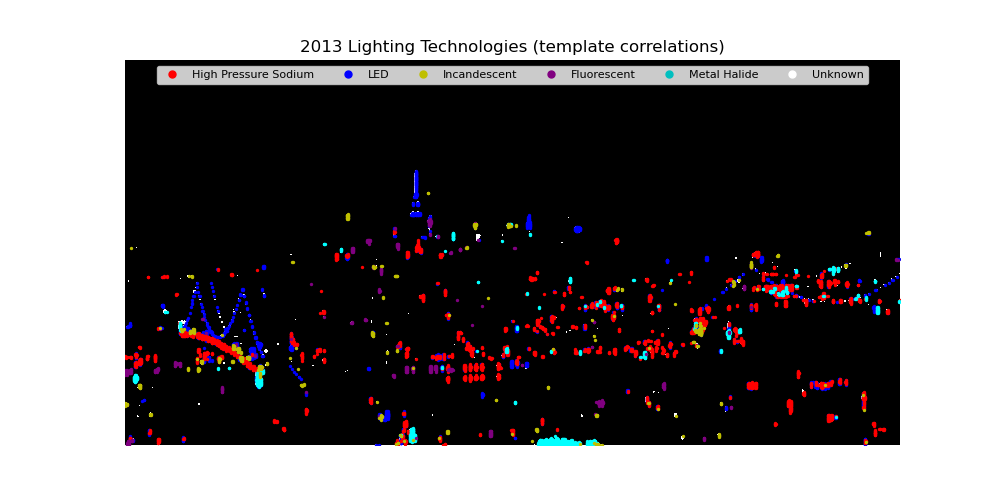

In [12]:
# -- plot 2013 labels
plot_labels(active13, loc13, ind13, labs13, 2013)

### Now 2018 correlations

In [13]:
# -- get the correlation coefficients
ccs18, labs18 = correlate_templates(specs18, templsinqe)

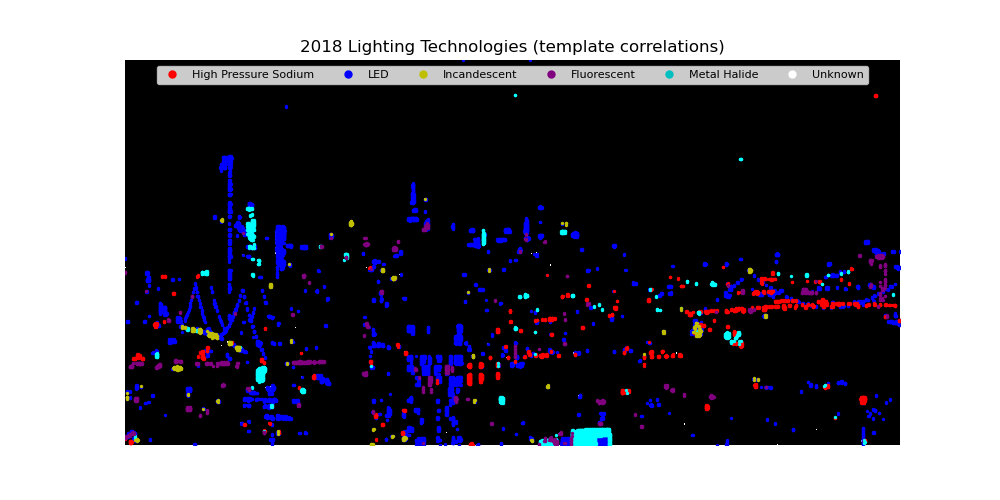

In [14]:
# -- plot 2018 labels
plot_labels(active18, loc18, ind18, labs18, 2018)